# Analysis for DataCrumbs

This is a simple analysis notebook for Datacrumbs.

## Imports

In [164]:
import logging
import json
import dask
import os
from pathlib import Path
from glob import glob
import math
import zindex_py as zindex
import numpy as np
import intervals as I
import pandas as pd
from tqdm.notebook import trange, tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [102]:
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster, progress, wait, get_client
from dask.distributed import Future, get_client

## Project Variables

In [103]:
app_root = str(Path(os.getcwd()).parent)

In [104]:
logging.basicConfig(
    level=logging.INFO,
    handlers=[
        logging.StreamHandler(),
    ],
    format="%(asctime)s [%(levelname)s]: %(message)s in %(pathname)s:%(lineno)d",
)

## Setup Dask Local Cluster

In [105]:
workers=16
cluster = LocalCluster(n_workers=workers)  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default
logging.info(f"Initialized Client with {workers} workers and link {client.dashboard_link}")

/usr/workspace/haridev/datacrumbs/venv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33359 instead
  warnings.warn(
2024-11-25 10:34:20,039 [INFO]: Initialized Client with 16 workers and link http://127.0.0.1:33359/status in /var/tmp/haridev/ipykernel_3691311/3142773904.py:4


## Start Analysis

In [240]:

import os 
is_trace = True
folder="/usr/workspace/haridev/xio/"
# file=f"{folder}/logs/ior/ior-256k.pfw.gz"
file=f"{folder}/logs/ior/ior-256k.pfw.gz"
# file=f"{folder}/logs/ops-32_files-8/RAW-BUF.pfw.gz"
# output_file=f"{folder}/output/jslines/read_ops-32_files-8-RAW-DIRECT.pfw.gz.jsonl"
output_file=f"{folder}/output/jslines/*_ops-32_files-8-RAW-DIRECT.pfw.gz.jsonl"
file_pattern = glob(file)
file_pattern,  glob(output_file)

(['/usr/workspace/haridev/xio//logs/ops-32_files-8/RAW-BUF.pfw.gz'],
 ['/usr/workspace/haridev/xio//output/jslines/write_ops-32_files-8-RAW-DIRECT.pfw.gz.jsonl',
  '/usr/workspace/haridev/xio//output/jslines/read_ops-32_files-8-RAW-DIRECT.pfw.gz.jsonl'])

## Function to load trace data

In [207]:
def create_index(filename):
    index_file = f"{filename}.zindex"
    if not os.path.exists(index_file):
        status = zindex.create_index(filename, index_file=f"file:{index_file}",
                                     regex="id:\b([0-9]+)", numeric=True, unique=True, debug=False, verbose=False)
        logging.debug(f"Creating Index for {filename} returned {status}")
    return filename

def get_linenumber(filename):
    index_file = f"{filename}.zindex"
    line_number = zindex.get_max_line(filename, index_file=index_file, debug=False, verbose=False)
    logging.debug(f" The {filename} has {line_number} lines")
    return (filename, line_number)

def get_size(filename):
    if filename.endswith('.pfw'):
        size = os.stat(filename).st_size
    elif filename.endswith('.pfw.gz'):
        index_file = f"{filename}.zindex"
        line_number = zindex.get_max_line(filename, index_file=index_file,debug=False, verbose=False)
        size = line_number * 256
    logging.debug(f" The {filename} has {size/1024**3} GB size")
    return int(size)


def generate_line_batches(filename, max_line):
    batch_size = 16*1024
    for start in range(0, max_line, batch_size):
        end =  min((start + batch_size - 1) , (max_line - 1))
        logging.debug(f"Created a batch for {filename} from [{start}, {end}] lines")
        yield filename, start, end

def load_indexed_gzip_files(filename, start, end):
    index_file = f"{filename}.zindex"
    json_lines = zindex.zquery(filename, index_file=index_file,
                          raw=f"select a.line from LineOffsets a where a.line >= {start} AND a.line <= {end};", debug=False, verbose=False)
    logging.debug(f"Read {len(json_lines)} json lines for [{start}, {end}]")
    return json_lines

In [208]:
def load_profile(line):
    d = {}
    if line is not None and line !="" and len(line) > 0 and "[" != line[0] and line != "\n" :
        try:
            unicode_line = ''.join([i if ord(i) < 128 else '#' for i in line])
            val = json.loads(unicode_line)
            if "pid" in d:
                d["pid"] = val["pid"]
            if "tid" in d:
                d["tid"] = val["tid"]
            if "ts" in d:
                d["ts_us"] = int(val["ts"])
            d["filename"] = "NA"
            if "args" in val:
                if "time" in val["args"]:
                    d["dur_sec"] = float(val["args"]["time"])
                if "freq" in val["args"]:
                    d["freq"] = val["args"]["freq"]
                if "size_sum" in val["args"]:
                    d["size_bytes"] = val["args"]["size_sum"]
                if "fname" in val["args"] and val["args"]["fname"]:
                    d["filename"] = val["args"]["fname"]
            d["func_id"] = val["name"]
            d["cat"] = val["cat"]
        except Exception as error:
            logging.error(f"Processing {line} failed with {error}")
    return d


def load_trace(line):
    d = {}
    if line is not None and line !="" and len(line) > 0 and "[" != line[0] and line != "\n" :
        try:
            unicode_line = ''.join([i if ord(i) < 128 else '#' for i in line])
            val = json.loads(unicode_line)
            d["name"] = val["name"]
            d["cat"] = val["cat"]
            if "pid" in val:
                d["pid"] = val["pid"]
            if "tid" in val:
                d["tid"] = val["tid"]
            d["ts"] = 0
            d["dur"] = 0
            if "ts" in val:
                d["ts"] = int(val["ts"])
                d["te"] = int(val["ts"])
            d["dur"] = 1
            if "dur" in val:
                d["dur"] = int(val["dur"])
            if "args" in val and "hhash" in val["args"]:                    
                d["hhash"] = val["args"]["hhash"]
            if "ts" in val:
                interval = I.closedopen(d["ts"], d["ts"] + 1)
                if d["dur"] > 0:
                    d["te"] = int(val["ts"]) + d["dur"]
                    interval = I.closedopen(d["ts"], d["ts"] + d["dur"])
                d["interval"] = I.to_string(interval)
            if val["ph"] != "M":
                d["type"] = 0    
                if "args" in val:                    
                    if "hhash" in val["args"]:
                        d["hhash"] = val["args"]["hhash"]
                    if "size_sum" in val["args"]:
                        d["size"] = val["args"]["size_sum"]
                    if "fhash" in val["args"]:
                        d["fhash"] = val["args"]["fhash"]
            else:
                if val["name"] == "FH":
                    d["type"] = 1
                    if "args" in val:
                        if "name" in val["args"]:
                            d["name"] = val["args"]["name"]
                        if "value" in val["args"]:
                            d["hash"] = val["args"]["value"]
                elif val["name"] == "HH":
                    d["type"] = 2
                    if "args" in val:
                        if "name" in val["args"]:
                            d["name"] = val["args"]["name"]
                        if "value" in val["args"]:
                            d["hash"] = val["args"]["value"]
            
        except Exception as error:
            logging.error(f"Processing {line} failed with {error}")
    return d

## Create Dask Dataframe

In [209]:
if len(file_pattern) > 0:
    dask.bag.from_sequence(file_pattern).map(create_index).compute()
    logging.info(f"Created index for {len(file_pattern)} files")
    total_size = dask.bag.from_sequence(file_pattern).map(get_size).sum()
    n_partition = math.ceil(total_size.compute() / (128 * 1024 ** 2))
    logging.info(f"Total size of all files are {total_size} bytes")
    max_line_numbers = dask.bag.from_sequence(file_pattern).map(get_linenumber).compute()
    logging.info(f"Max lines per file are {max_line_numbers}")
    json_line_delayed = []
    total_lines = 0
    for filename, max_line in max_line_numbers:
        total_lines += max_line
        for _, start, end in generate_line_batches(filename, max_line):
            json_line_delayed.append((filename, start, end))

    logging.info(f"Loading {len(json_line_delayed)} batches out of {len(file_pattern)} files and has {total_lines} lines overall")
    json_line_bags = []
    for filename, start, end in json_line_delayed:
        num_lines = end - start + 1
        json_line_bags.append(dask.delayed(load_indexed_gzip_files, nout=num_lines)(filename, start, end))
    json_lines = dask.bag.concat(json_line_bags)
    if is_trace:
        pfw_bag = json_lines.map(load_trace).filter(lambda x: "name" in x)
    else:
        pfw_bag = json_lines.map(load_profile).filter(lambda x: "func_id" in x)
    pfw_bag.take(1)

2024-11-25 11:13:34,638 [INFO]: Created index for 1 files in /var/tmp/haridev/ipykernel_3691311/864066620.py:3
2024-11-25 11:13:35,000 [INFO]: Total size of all files are <dask.bag.core.Item object at 0x155214cc39d0> bytes in /var/tmp/haridev/ipykernel_3691311/864066620.py:6
2024-11-25 11:13:35,490 [INFO]: Max lines per file are [('/usr/workspace/haridev/xio//logs/ops-32_files-8/RAW-BUF.pfw.gz', 4906748)] in /var/tmp/haridev/ipykernel_3691311/864066620.py:8
2024-11-25 11:13:35,496 [INFO]: Loading 300 batches out of 1 files and has 4906748 lines overall in /var/tmp/haridev/ipykernel_3691311/864066620.py:16


In [210]:
if is_trace:
    columns = {'hhash': "string[pyarrow]", 'pid': "uint64[pyarrow]", 'tid': "uint64[pyarrow]",
                'cat': "string[pyarrow]", 'name': "string[pyarrow]", 'type':  "uint8[pyarrow]",
            'ts': "uint64[pyarrow]", 'te': "uint64[pyarrow]", 'dur': "uint64[pyarrow]", 'interval': "string[pyarrow]", 
             'size': "uint64[pyarrow]", 'fhash': "string[pyarrow]", 'hash': "string[pyarrow]", 
           }
else:
    columns = {'pid': "uint64[pyarrow]", 'tid': "uint64[pyarrow]",
            'ts_us': "uint64[pyarrow]", 'dur_sec': "float32[pyarrow]", 
            'freq': "uint64[pyarrow]", 'size_bytes': "uint64[pyarrow]", 'name': "string[pyarrow]", 
            'filename': "string[pyarrow]", 
            'cat': "string[pyarrow]"}

In [211]:
events = pfw_bag.to_dataframe(meta=columns)

In [212]:
events = events.repartition(npartitions=n_partition).persist()
_ = wait(events)

In [219]:
fhash = events.query("type == 1")[["name","hash"]]
hhash = events.query("type == 2")[["name","hash"]]
event = events.query("type == 0")
# fhashes = fhash.query("name.str.contains('test.bat')").compute()["hash"]
fhashes = fhash.query("name.str.contains('file_0')").compute()["hash"]
fhashes = fhashes.to_list()


In [220]:
op="read"

## Analysis

In [221]:
event["name"].unique().compute()

0              page_add_file_rmap
1                  vm_normal_page
2            khugepaged_enter_vma
3                   release_pages
4                       init_file
                 ...             
36          ext4_invalidate_folio
37              ext4_ext_truncate
38          ext4_put_io_end_defer
39               bio_to_wbt_flags
40    ext4_datasem_ensure_credits
Name: name, Length: 469, dtype: string

In [222]:

interesting_events = event.query("fhash.isin(@value) and name == @op", local_dict={"value": fhashes, "op":op}).sort_values("ts").reset_index()
interesting_events.compute()

,index,hhash,pid,tid,cat,name,type,ts,te,dur,interval,size,fhash,hash
0,1897,ecd9cccc050c9e893ab33b1a228fe76d,102273,102273,sys,read,0,461929060,461989691,60631,"[461929060,461989691)",1024,2337428835aa42fa0d2764000f669460,<NA>
1,1976,ecd9cccc050c9e893ab33b1a228fe76d,102273,102273,sys,read,0,463185949,463209344,23395,"[463185949,463209344)",1024,2337428835aa42fa0d2764000f669460,<NA>
2,2035,ecd9cccc050c9e893ab33b1a228fe76d,102273,102273,sys,read,0,464367094,464391244,24150,"[464367094,464391244)",1024,2337428835aa42fa0d2764000f669460,<NA>
3,2094,ecd9cccc050c9e893ab33b1a228fe76d,102273,102273,sys,read,0,465542671,465557657,14986,"[465542671,465557657)",1024,2337428835aa42fa0d2764000f669460,<NA>
4,2215,ecd9cccc050c9e893ab33b1a228fe76d,102273,102273,sys,read,0,466807632,466862256,54624,"[466807632,466862256)",1024,2337428835aa42fa0d2764000f669460,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,9763,ecd9cccc050c9e893ab33b1a228fe76d,103600,103600,sys,read,0,157323589364,157323670567,81203,"[157323589364,157323670567)",16384,4399451135d75f5c5be27cd4057b34c8,<NA>
568,9825,ecd9cccc050c9e893ab33b1a228fe76d,103600,103600,sys,read,0,157325455056,157325483484,28428,"[157325455056,157325483484)",16384,4399451135d75f5c5be27cd4057b34c8,<NA>
569,9921,ecd9cccc050c9e893ab33b1a228fe76d,103600,103600,sys,read,0,157327418547,157327499293,80746,"[157327418547,157327499293)",16384,4399451135d75f5c5be27cd4057b34c8,<NA>
570,9983,ecd9cccc050c9e893ab33b1a228fe76d,103600,103600,sys,read,0,157329298722,157329325714,26992,"[157329298722,157329325714)",16384,4399451135d75f5c5be27cd4057b34c8,<NA>


In [217]:
# page_cache_fn = ["mark_buffer_dirty", "mark_page_accessed", "do_page_cache_ra", "__page_cache_alloc", "alloc_pages"]
page_cache_fn = ["mark_page_accessed", "do_page_cache_ra"]
interesting_os_events = event.query("name.isin(@value)", local_dict={"value": page_cache_fn}).sort_values("ts").reset_index()
interesting_os_events.compute()

,index,hhash,pid,tid,cat,name,type,ts,te,dur,interval,size,fhash,hash
0,3114,ecd9cccc050c9e893ab33b1a228fe76d,102273,102273,os_cache,mark_page_accessed,0,26284871,26285416,545,"[26284871,26285416)",<NA>,<NA>,<NA>
1,3164,ecd9cccc050c9e893ab33b1a228fe76d,102273,102273,os_cache,mark_page_accessed,0,26358195,26358445,250,"[26358195,26358445)",<NA>,<NA>,<NA>
2,3171,ecd9cccc050c9e893ab33b1a228fe76d,102273,102273,os_cache,mark_page_accessed,0,26364222,26364387,165,"[26364222,26364387)",<NA>,<NA>,<NA>
3,3178,ecd9cccc050c9e893ab33b1a228fe76d,102273,102273,os_cache,mark_page_accessed,0,26369953,26370119,166,"[26369953,26370119)",<NA>,<NA>,<NA>
4,3252,ecd9cccc050c9e893ab33b1a228fe76d,102273,102273,os_cache,mark_page_accessed,0,26450628,26450823,195,"[26450628,26450823)",<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3590,5402,ecd9cccc050c9e893ab33b1a228fe76d,103568,103568,os_cache,mark_page_accessed,0,150499097415,150499097577,162,"[150499097415,150499097577)",<NA>,<NA>,<NA>
3591,5408,ecd9cccc050c9e893ab33b1a228fe76d,103568,103568,os_cache,mark_page_accessed,0,150499101657,150499101823,166,"[150499101657,150499101823)",<NA>,<NA>,<NA>
3592,5415,ecd9cccc050c9e893ab33b1a228fe76d,103568,103568,os_cache,mark_page_accessed,0,150499106806,150499106972,166,"[150499106806,150499106972)",<NA>,<NA>,<NA>
3593,5546,ecd9cccc050c9e893ab33b1a228fe76d,103568,103568,os_cache,mark_page_accessed,0,150499335738,150499335969,231,"[150499335738,150499335969)",<NA>,<NA>,<NA>


In [218]:
interesting_intervals  = interesting_events[["interval","name"]].compute()
interesting_intervals

,interval,name


In [168]:
def group_func(df):
    val = I.empty()
    for index, value in df.items():
        if str(value) != 'NA':
            pad_interval = I.from_string(str(value), int)
            val = val.union(pad_interval)
    logging.debug(f"Grouped Range into {val}")
    return I.to_string(val)
def union_portions():
    return dd.Aggregation(
        'union_portions',
        chunk=lambda s: s.apply(group_func),
        agg=lambda s: s.apply(group_func)
    )
relevant_intervals = interesting_events[["interval"]].reduction(chunk=lambda s: s.apply(group_func), aggregate=lambda s1: s1.apply(group_func))["interval"].compute()
relevant_intervals = I.from_string(relevant_intervals, int)
relevant_intervals_list = list(relevant_intervals)
relevant_intervals_list[:10], len(relevant_intervals_list)

([[364433934628,364434044129),
  [364434072479,364434103955),
  [364434127259,364434153835),
  [364434185620,364434201105),
  [364434213785,364434228566),
  [364434241062,364434255371),
  [364434267872,364434282735),
  [364434295173,364434310794),
  [364434322980,364434337184),
  [364434349445,364434363534)],
 13719)

In [169]:
min_ts = relevant_intervals_list[0].lower
max_te = relevant_intervals_list[-1].upper
min_ts, max_te

(364433934628, 492763177656)

In [170]:
filtered_events = event.query(f"ts >= {min_ts - 1e5} and te <= {max_te + 1e5} and dur > 0")
filtered_events.compute()
# filtered_events = event

,hhash,pid,tid,cat,name,type,ts,te,dur,interval,size,fhash,hash
15725,ecd9cccc050c9e893ab33b1a228fe76d,11702,11702,kernel,hook_file_alloc_security,0,364433841491,364433842444,953,"[364433841491,364433842444)",<NA>,<NA>,<NA>
15726,ecd9cccc050c9e893ab33b1a228fe76d,11702,11702,kernel,apparmor_file_alloc_security,0,364433843794,364433845081,1287,"[364433843794,364433845081)",<NA>,<NA>,<NA>
15727,ecd9cccc050c9e893ab33b1a228fe76d,11702,11702,kernel,security_file_alloc,0,364433839371,364433845914,6543,"[364433839371,364433845914)",<NA>,<NA>,<NA>
15728,ecd9cccc050c9e893ab33b1a228fe76d,11702,11702,kernel,init_file,0,364433837228,364433846868,9640,"[364433837228,364433846868)",<NA>,<NA>,<NA>
15730,ecd9cccc050c9e893ab33b1a228fe76d,11702,11702,kernel,make_vfsuid,0,364433850464,364433851461,997,"[364433850464,364433851461)",<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,ecd9cccc050c9e893ab33b1a228fe76d,11702,11702,kernel,filemap_read,0,492762234308,492762238677,4369,"[492762234308,492762238677)",<NA>,<NA>,<NA>
613,ecd9cccc050c9e893ab33b1a228fe76d,11702,11702,kernel,aa_file_perm,0,492762460613,492762460932,319,"[492762460613,492762460932)",<NA>,<NA>,<NA>
614,ecd9cccc050c9e893ab33b1a228fe76d,11702,11702,kernel,make_vfsuid,0,492762672384,492762672697,313,"[492762672384,492762672697)",<NA>,<NA>,<NA>
615,ecd9cccc050c9e893ab33b1a228fe76d,11702,11702,kernel,aa_file_perm,0,492762963075,492762963394,319,"[492762963075,492762963394)",<NA>,<NA>,<NA>


In [181]:
filtered_events["combined_name"] = filtered_events["name"] + "-" + filtered_events["cat"]
event_batch_per_sys_call = []
rows = list(interesting_intervals.iterrows())[:1000]
count = 0
ops_map = {}
ops_counter = 0
for index, row in tqdm(rows):
    interval = I.from_string(row["interval"], int)
    ops = row["name"]
    a_overlaps_b = f"(ts >= {interval.lower} and ts <=  {interval.upper}) or (te >= {interval.lower} and te <=  {interval.upper})"
    b_overlaps_a = f"({interval.lower} >= ts and {interval.lower} <=  te) or ({interval.upper} >= ts and {interval.upper} <=  te)"
    batch = filtered_events.query(f"{a_overlaps_b} or {b_overlaps_a}")[["combined_name", "dur"]].groupby("combined_name").sum()
    if ops in ops_map:
        op_value = ops_map[ops]
    else:
        ops_counter += 1
        op_value = ops_counter
        ops_map[ops] = op_value
    event_batch_per_sys_call.append(batch)
    count += 1
event_batch_per_sys_call_compute = dask.compute(event_batch_per_sys_call)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [182]:
merged_df = None
count = 0
for batch in tqdm(event_batch_per_sys_call_compute[0]):
    if merged_df is not None:
        merged_df = merged_df.merge(batch, how='outer', on="combined_name",suffixes=('', f"_{count}"))
    else:
        merged_df = batch
    count += 1

  0%|          | 0/1000 [00:00<?, ?it/s]

In [185]:
dataset = merged_df.transpose()
dataset

combined_name,__ext4_get_inode_loc-kernel,__ext4_handle_dirty_metadata-kernel,__ext4_journal_get_write_access-kernel,__ext4_journal_start_sb-kernel,__ext4_journal_stop-kernel,__ext4_mark_inode_dirty-kernel,__find_get_block-kernel,__jbd2_journal_file_buffer-kernel,aa_file_perm-kernel,apparmor_file_permission-kernel,...,filemap_get_pages-kernel,filemap_get_read_batch-kernel,filemap_read-kernel,generic_file_read_iter-kernel,make_vfsgid-kernel,make_vfsuid-kernel,read-sys,rw_verify_area-vfs,security_file_permission-kernel,vfs_read-vfs
dur,11361,3413,5270,5350,1847,52854,1956,2500,887,3897,...,4337,2073,83844,86308,870,747,109501,9560,6883,104458
dur_1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,800,3070,...,3086,1190,11006,12880,760,730,31476,7850,5523,27687
dur_2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,707,2497,...,2703,1023,9813,11364,647,687,26576,6090,4334,23220
dur_3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,372,1471,...,1396,588,5400,6247,347,362,15485,3972,2779,13633
dur_4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,384,1296,...,1382,591,5614,6477,346,353,14781,3242,2297,12948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dur_995,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,340,1560,...,1322,483,4912,5795,293,305,14132,3633,2707,12488
dur_996,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,313,1105,...,1337,491,5115,5980,297,303,13359,2820,2070,11635
dur_997,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,338,1447,...,1379,540,5059,5958,296,307,13555,3176,2326,12010
dur_998,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,306,1100,...,1216,491,4933,5794,311,313,13095,2713,1959,11328


In [186]:
dataset.columns

Index(['__ext4_get_inode_loc-kernel', '__ext4_handle_dirty_metadata-kernel',
       '__ext4_journal_get_write_access-kernel',
       '__ext4_journal_start_sb-kernel', '__ext4_journal_stop-kernel',
       '__ext4_mark_inode_dirty-kernel', '__find_get_block-kernel',
       '__jbd2_journal_file_buffer-kernel', 'aa_file_perm-kernel',
       'apparmor_file_permission-kernel', 'ext4_dirty_inode-kernel',
       'ext4_fc_track_inode-kernel', 'ext4_file_read_iter-kernel',
       'ext4_fill_raw_inode-kernel', 'ext4_get_group_desc-kernel',
       'ext4_get_inode_loc-kernel', 'ext4_inode_csum-kernel',
       'ext4_inode_csum_set-kernel', 'ext4_inode_table-kernel',
       'ext4_journal_check_start-kernel', 'ext4_mark_iloc_dirty-kernel',
       'ext4_reserve_inode_write-kernel', 'filemap_get_pages-kernel',
       'filemap_get_read_batch-kernel', 'filemap_read-kernel',
       'generic_file_read_iter-kernel', 'make_vfsgid-kernel',
       'make_vfsuid-kernel', 'read-sys', 'rw_verify_area-vfs',
       '

<Axes: >

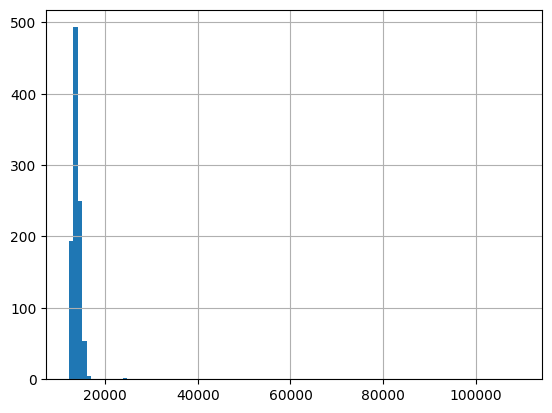

In [187]:
dataset["read-sys"].hist(bins=100)

In [241]:
def load_trace(trace):
    return dd.read_json(trace)

def load_traces(regex_file):
    files = glob(f"{regex_file}")
    final_dataset_l = []
    for file in files:
        final_dataset_l.append(load_trace(file))
    final_dataset = dd.concat(final_dataset_l).compute().reset_index().drop("index", axis=1)
    return final_dataset

In [243]:
dataset = load_traces(output_file)
dataset.columns

Index(['__alloc_pages-kernel', '__bio_add_page-kernel',
       '__bio_iov_iter_get_pages-kernel', '__bio_split_to_limits-kernel',
       '__blk_bios_map_sg-kernel', '__ext4_ext_dirty-kernel',
       '__ext4_get_inode_loc-kernel', '__ext4_handle_dirty_metadata-kernel',
       '__ext4_journal_get_create_access-kernel',
       '__ext4_journal_get_write_access-kernel',
       ...
       'follow_page_pte-kernel', 'free_unref_page_list-kernel', 'main-app',
       'make_vfsgid-kernel', 'make_vfsuid-kernel',
       'mark_page_accessed-os_cache', 'release_pages-kernel',
       'try_grab_page-kernel', 'vfs_read-vfs', 'vm_normal_page-kernel'],
      dtype='object', length=192)

In [247]:
page_cache_fn = ["mark_buffer_dirty", "mark_page_accessed", "do_page_cache_ra", "__page_cache_alloc", "alloc_pages", "mark_buffer_dirty", "add_to_page_cache_lru", "account_page_dirtied"]
for column in dataset.columns:
    values = column.split("-")
    if column in page_cache_fn or values[0] in page_cache_fn:
        print(column)

alloc_pages-kernel
mark_page_accessed-os_cache


In [238]:
cached_reads = dataset[['vfs_read-vfs', 'mark_page_accessed-os_cache']]
cached_reads[cached_reads['mark_page_accessed-os_cache'].notnull()]

,vfs_read-vfs,mark_page_accessed-os_cache
4096,1373243,885.0
4352,293219,878.0
4608,291879,883.0
4864,2065159,867.0
5120,289062,875.0
5376,294051,856.0
5632,297834,843.0
5888,292263,879.0
6144,1320408,3306.0


In [239]:
cached_reads

,vfs_read-vfs,mark_page_accessed-os_cache
0,150886,NaN
1,165743,NaN
2,131196,NaN
3,198183,NaN
4,135656,NaN
...,...,...
6395,451540,NaN
6396,479202,NaN
6397,445734,NaN
6398,1523898,NaN


<Axes: >

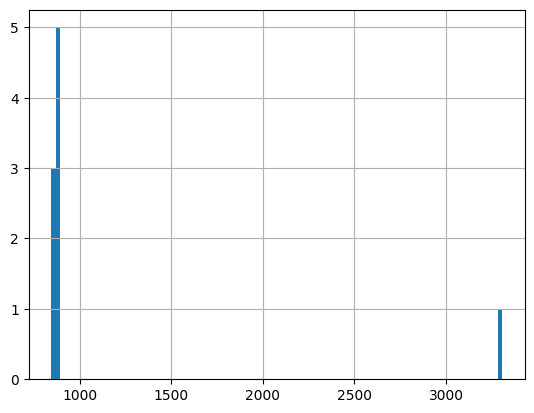

In [228]:
dataset['mark_page_accessed-os_cache'].hist(bins=100)

In [ ]:
read_durations = interesting_events.query("name == 'read'")[["dur"]]
#print(read_durations)
read_durations.compute().hist(bins=10) #[0, int(1e3), int(1e4), int(1e6), int(1e7), int(1e8), int(1e9)])

In [ ]:
read_durations["count"] = 1
read_durations["count"].sum().compute()

In [ ]:
page_access = event.query("name == 'mark_page_accessed'")
page_access["count"] = 1
page_access["count"].sum().compute()